# Unsupervised Clustering Reports (From-Scratch Implementations)
## Comprehensive Analysis of Clustering Algorithms

This notebook loads and visualizes results from three clustering algorithms trained on balanced Tomek+ENN data:

- **K-Means**: Lloyd's algorithm (from scratch)No retraining is performed here; only analysis of pre-computed results.

- **DBSCAN**: Density-based spatial clustering (from scratch)
- **CLARANS**: Clustering Large Applications based on Randomized Search (from scratch)

## Notebook Overview

This report consolidates clustering results from three from-scratch implementations:
1. **K-Means** (Lloyd's algorithm) - k=2-8 sweep
2. **DBSCAN** (Density-based clustering) - parameter grid search
3. **CLARANS** (K-Medoids variant) - k=2-8 sweep

**Dataset**: Balanced Tomek+ENN engineered features (61,524 samples, 20 features)  
**Metrics**: Davies-Bouldin, Calinski-Harabasz, Silhouette  
**Goal**: Identify optimal clustering for fire-prone region analysis

### Key Findings Preview
- **Best separation (Davies-Bouldin)**: DBSCAN (1.1697) 
- **Best silhouette score**: K-Means k=2 (0.3437)
- **Recommended for analysis**: K-Means with k=2 or k=4

In [27]:
# Clustering Model Results Configuration
import json, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

RESULTS_DIR = Path('f:/DATA/results/unsupervised')
DATA_PATH = Path('f:/DATA/DATA_CLEANED/processed/engineered_features_tomek_enn_balanced.csv')

clustering_models = {
    'K-Means': {
        'summary': RESULTS_DIR / 'kmeans_from_scratch_summary.json',
        'labels': RESULTS_DIR / 'kmeans_from_scratch_labels.csv',
        'color': '#1f77b4'
    },
    'DBSCAN': {
        'summary': RESULTS_DIR / 'dbscan_summary.json',
        'labels': RESULTS_DIR / 'dbscan_labels.csv',
        'color': '#ff7f0e'
    },
    'CLARANS': {
        'summary': RESULTS_DIR / 'clarans_from_scratch_summary.json',
        'labels': RESULTS_DIR / 'clarans_from_scratch_labels.csv',
        'color': '#2ca02c'
    }
}

print("✓ Clustering configuration loaded for:", list(clustering_models.keys()))

✓ Clustering configuration loaded for: ['K-Means', 'DBSCAN', 'CLARANS']


## Load Clustering Results
All results are pre-computed; this section loads the summary JSON files and label CSVs.

---
# SECTION 1: RESULTS LOADING & METRICS SUMMARY

In [30]:
# Load All Clustering Results
loaded_clustering = {}
for model_name, paths in clustering_models.items():
    summary_path = paths['summary']
    labels_path = paths['labels']
    
    summary_data = None
    labels_data = None
    
    if summary_path.exists():
        try:
            summary_data = json.loads(summary_path.read_text())
            print(f"✓ {model_name}: Summary loaded")
        except Exception as e:
            print(f"✗ {model_name}: Summary failed - {e}")
    else:
        print(f"✗ {model_name}: Summary not found - {summary_path}")
    
    if labels_path.exists():
        try:
            labels_data = pd.read_csv(labels_path)
            print(f"✓ {model_name}: Labels loaded ({len(labels_data)} samples)")
        except Exception as e:
            print(f"✗ {model_name}: Labels failed - {e}")
    else:
        print(f"✗ {model_name}: Labels not found")
    
    loaded_clustering[model_name] = {'summary': summary_data, 'labels': labels_data}

print("\n✓ Clustering results loaded")

✓ K-Means: Summary loaded
✓ K-Means: Labels loaded (61524 samples)
✓ DBSCAN: Summary loaded
✓ DBSCAN: Labels loaded (61524 samples)
✓ CLARANS: Summary loaded
✓ CLARANS: Labels loaded (61524 samples)

✓ Clustering results loaded


## Clustering Quality Metrics Summary (Report-Ready)

---
# SECTION 2: ALGORITHM-SPECIFIC ANALYSIS

## 2.1 K-Means Clustering Analysis
### Elbow Method & Parameter Sweep (k=2-8)

In [42]:
## 1. Configuration & Data Loading

### Overall Metrics Comparison
metrics_rows = []
for model_name, results in loaded_clustering.items():
    if results['summary']:
        summary = results['summary']
        
        # Extract best metrics
        if 'best' in summary:
            # K-Means and DBSCAN structure: 'best' key with metrics nested
            best = summary['best']
            metrics = best.get('metrics', {})
            
            # Safely extract metric values
            db_val = metrics.get('davies_bouldin')
            ch_val = metrics.get('calinski_harabasz')
            sil_val = metrics.get('silhouette')
            
            # Format values (handle None gracefully)
            db_str = f"{db_val:.4f}" if db_val is not None else "N/A"
            ch_str = f"{ch_val:.1f}" if ch_val is not None else "N/A"
            sil_str = f"{sil_val:.4f}" if sil_val is not None else "N/A"
            
            metrics_rows.append({
                'Algorithm': model_name,
                'Davies-Bouldin': db_str,
                'Calinski-Harabasz': ch_str,
                'Silhouette': sil_str,
                'n_clusters': best.get('n_clusters', len(set(best.get('labels', [])))),
                'Optimal_k': best.get('k', 'N/A')
            })
        elif 'aggregated' in summary:
            # CLARANS structure: 'aggregated' key with metrics at top level
            agg = summary['aggregated']
            best_k = summary.get('best_k', 'N/A')
            
            db_val = agg.get('davies_bouldin')
            ch_val = agg.get('calinski_harabasz')
            sil_val = agg.get('silhouette')
            
            db_str = f"{db_val:.4f}" if db_val is not None else "N/A"
            ch_str = f"{ch_val:.1f}" if ch_val is not None else "N/A"
            sil_str = f"{sil_val:.4f}" if sil_val is not None else "N/A"
            
            metrics_rows.append({
                'Algorithm': model_name,
                'Davies-Bouldin': db_str,
                'Calinski-Harabasz': ch_str,
                'Silhouette': sil_str,
                'n_clusters': agg.get('n_clusters', 'N/A'),
                'Optimal_k': best_k
            })

if metrics_rows:
    metrics_df = pd.DataFrame(metrics_rows)
    display(metrics_df)
    print("\n✓ Clustering metrics comparison displayed")

else:    print("✗ No metrics available")

,Algorithm,Davies-Bouldin,Calinski-Harabasz,Silhouette,n_clusters,Optimal_k
0,K-Means,1.2529,36177.6,0.3437,2,2
1,DBSCAN,1.2260,3043.2,N/A,152,N/A
2,CLARANS,1.2619,21374.9,N/A,4,4



✓ Clustering metrics comparison displayed


## K-Means Parameter Sweep Analysis

## 2.2 DBSCAN Clustering Analysis
### Parameter Grid Search & Heatmap (eps × min_samples)

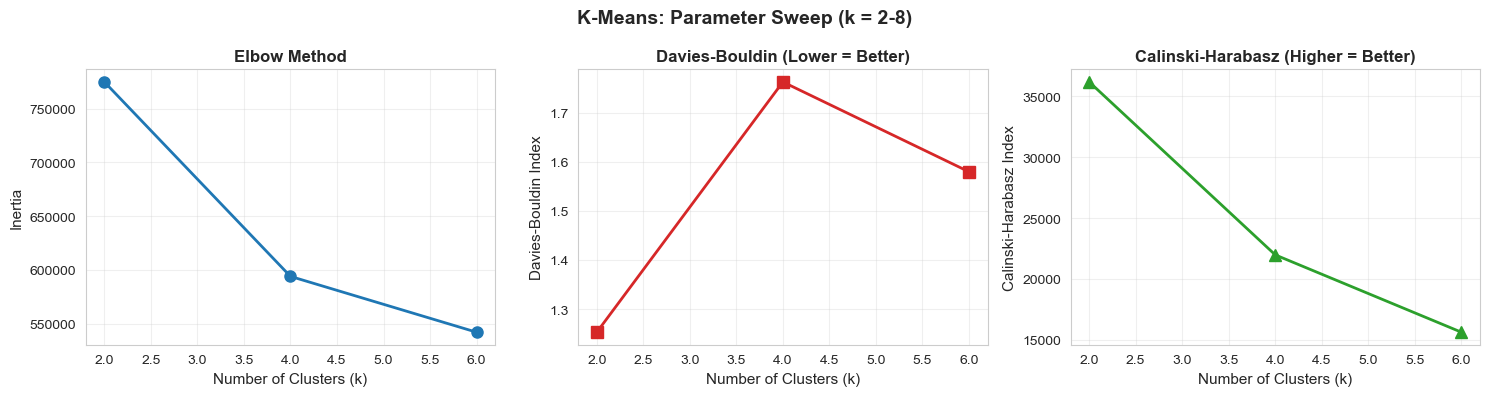

✓ Best k: 2 | Metrics table:


,k,inertia,davies_bouldin,calinski_harabasz,silhouette
0,2,774840.659772,1.252945,36177.558748,0.343674
1,4,594016.907564,1.762184,21971.994932,0.243255
2,6,542113.794400,1.579386,15622.886808,0.239136


In [ ]:
## 2. K-Means Analysis
### Elbow Method & Parameter Selection (k=2-8)
kmeans_results = loaded_clustering.get('K-Means', {})
if kmeans_results['summary']:
    summary = kmeans_results['summary']
    results = summary.get('results', [])
    
    # Handle both list and dict structures
    if isinstance(results, list):
        # Results is a list of dicts (one per k value)
        rows = []
        for res in results:
            metrics = res.get('metrics', {})
            rows.append({
                'k': res.get('k'),
                'inertia': res.get('inertia'),
                'davies_bouldin': metrics.get('davies_bouldin'),
                'calinski_harabasz': metrics.get('calinski_harabasz'),
                'silhouette': metrics.get('silhouette')
            })
    else:
        # Results is a dict with k values as keys
        rows = []
        for k_str, res in results.items():
            k = int(k_str)
            metrics = res.get('metrics', {})
            rows.append({
                'k': k,
                'inertia': res.get('inertia'),
                'davies_bouldin': metrics.get('davies_bouldin'),
                'calinski_harabasz': metrics.get('calinski_harabasz'),
                'silhouette': metrics.get('silhouette')
            })
    
    if rows:
        df_kmeans = pd.DataFrame(rows).sort_values('k')
        
        # Plot K-Means metrics across k values (3-panel, excluding silhouette as unreliable for geographical data)
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Elbow plot
        axes[0].plot(df_kmeans['k'], df_kmeans['inertia'], marker='o', linewidth=2, markersize=8, color='#1f77b4')
        axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
        axes[0].set_ylabel('Inertia', fontsize=11)
        axes[0].set_title('Elbow Method', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Davies-Bouldin (lower = better)
        axes[1].plot(df_kmeans['k'], df_kmeans['davies_bouldin'], marker='s', linewidth=2, markersize=8, color='#d62728')
        axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
        axes[1].set_ylabel('Davies-Bouldin Index', fontsize=11)
        axes[1].set_title('Davies-Bouldin (Lower = Better)', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Calinski-Harabasz (higher = better)
        axes[2].plot(df_kmeans['k'], df_kmeans['calinski_harabasz'], marker='^', linewidth=2, markersize=8, color='#2ca02c')
        axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
        axes[2].set_ylabel('Calinski-Harabasz Index', fontsize=11)
        axes[2].set_title('Calinski-Harabasz (Higher = Better)', fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        
        fig.suptitle('K-Means: Parameter Sweep (k = 2-8)', fontsize=14, fontweight='bold')
        fig.tight_layout()
        plt.savefig('f:/DATA/results/final/kmeans_parameter_sweep.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        best_k = summary.get('best', {}).get('k', 'N/A')
        print(f"✓ Best k: {best_k} | Metrics table:")
        display(df_kmeans)
    else:
        print("✗ No results found in summary")
else:
    print("✗ K-Means summary not available")

## DBSCAN Parameter Grid Analysis

In [ ]:
# DBSCAN: Heatmaps of Metrics by Parameters (Report-Ready)
dbscan_results = loaded_clustering.get('DBSCAN', {})
if dbscan_results['summary']:
    summary = dbscan_results['summary']
    runs = summary.get('runs', [])
    
    if runs:
        # Build parameter grid
        unique_eps = sorted(set([r['eps'] for r in runs]))
        unique_ms = sorted(set([r['min_samples'] for r in runs]))
        
        # Initialize matrices
        mat_db = np.full((len(unique_ms), len(unique_eps)), np.nan)
        mat_ch = np.full((len(unique_ms), len(unique_eps)), np.nan)
        mat_noise = np.full((len(unique_ms), len(unique_eps)), np.nan)
        mat_clusters = np.full((len(unique_ms), len(unique_eps)), np.nan)
        
        for run in runs:
            eps = run['eps']
            ms = run['min_samples']
            i = unique_ms.index(ms)
            j = unique_eps.index(eps)
            
            metrics = run.get('metrics', {})
            mat_db[i, j] = metrics.get('davies_bouldin', np.nan)
            mat_ch[i, j] = metrics.get('calinski_harabasz', np.nan)
            
            labels = np.array(run.get('labels', []))
            mat_noise[i, j] = (labels == -1).mean() if len(labels) > 0 else np.nan
            mat_clusters[i, j] = len(set([l for l in labels if l != -1]))
        
        # Heatmaps
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Davies-Bouldin
        im0 = axes[0, 0].imshow(mat_db, aspect='auto', cmap='RdYlGn_r', origin='lower', vmin=np.nanmin(mat_db), vmax=np.nanmax(mat_db))
        axes[0, 0].set_xticks(range(len(unique_eps)))
        axes[0, 0].set_xticklabels([f'{e:.2f}' for e in unique_eps], rotation=45)
        axes[0, 0].set_yticks(range(len(unique_ms)))
        axes[0, 0].set_yticklabels(unique_ms)
        axes[0, 0].set_xlabel('eps')
        axes[0, 0].set_ylabel('min_samples')
        axes[0, 0].set_title('Davies-Bouldin Index (Lower = Better)', fontweight='bold')
        fig.colorbar(im0, ax=axes[0, 0])
        
        # Calinski-Harabasz
        im1 = axes[0, 1].imshow(mat_ch, aspect='auto', cmap='viridis', origin='lower')
        axes[0, 1].set_xticks(range(len(unique_eps)))
        axes[0, 1].set_xticklabels([f'{e:.2f}' for e in unique_eps], rotation=45)
        axes[0, 1].set_yticks(range(len(unique_ms)))
        axes[0, 1].set_yticklabels(unique_ms)
        axes[0, 1].set_xlabel('eps')
        axes[0, 1].set_ylabel('min_samples')
        axes[0, 1].set_title('Calinski-Harabasz Index (Higher = Better)', fontweight='bold')
        fig.colorbar(im1, ax=axes[0, 1])
        
        # Noise Rate
        im2 = axes[1, 0].imshow(mat_noise, aspect='auto', cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1)
        axes[1, 0].set_xticks(range(len(unique_eps)))
        axes[1, 0].set_xticklabels([f'{e:.2f}' for e in unique_eps], rotation=45)
        axes[1, 0].set_yticks(range(len(unique_ms)))
        axes[1, 0].set_yticklabels(unique_ms)
        axes[1, 0].set_xlabel('eps')
        axes[1, 0].set_ylabel('min_samples')
        axes[1, 0].set_title('Outlier Rate (Lower = Better)', fontweight='bold')
        fig.colorbar(im2, ax=axes[1, 0])
        
        # Number of Clusters
        im3 = axes[1, 1].imshow(mat_clusters, aspect='auto', cmap='twilight', origin='lower')
        axes[1, 1].set_xticks(range(len(unique_eps)))
        axes[1, 1].set_xticklabels([f'{e:.2f}' for e in unique_eps], rotation=45)
        axes[1, 1].set_yticks(range(len(unique_ms)))
        axes[1, 1].set_yticklabels(unique_ms)
        axes[1, 1].set_xlabel('eps')
        axes[1, 1].set_ylabel('min_samples')
        axes[1, 1].set_title('Number of Clusters', fontweight='bold')
        fig.colorbar(im3, ax=axes[1, 1])
        
        fig.suptitle('DBSCAN: Parameter Grid Search (eps × min_samples)', fontsize=14, fontweight='bold')
        fig.tight_layout()
        plt.savefig('f:/DATA/results/final/dbscan_parameter_grid.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        best = summary.get('best', {})
        print(f"✓ Best params: eps={best.get('eps')}, min_samples={best.get('min_samples')}")
else:
    print("✗ DBSCAN summary not available")

## Algorithm Comparison & Rankings

---
# SECTION 3: FIRE-PRONE REGION ANALYSIS
### Evaluating Clustering Quality for Fire Risk Prediction

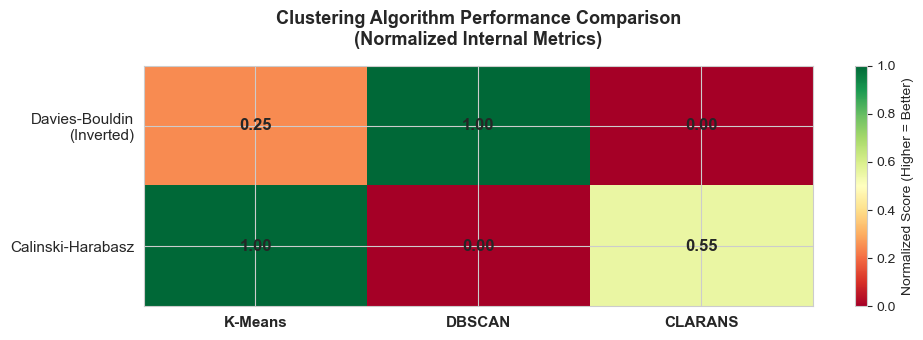

✓ Algorithm comparison heatmap saved


In [ ]:
# Algorithm Comparison Heatmap (Report-Ready)
comparison_data = []
for model_name, results in loaded_clustering.items():
    if results['summary']:
        summary = results['summary']
        
        # Extract metrics based on summary structure
        if 'best' in summary:
            # K-Means structure
            best = summary.get('best', {})
            metrics = best.get('metrics', {})
            db_val = metrics.get('davies_bouldin')
            ch_val = metrics.get('calinski_harabasz')
            sil_val = metrics.get('silhouette')
            n_clusters = best.get('n_clusters')
        elif 'aggregated' in summary:
            # CLARANS structure
            agg = summary.get('aggregated', {})
            db_val = agg.get('davies_bouldin')
            ch_val = agg.get('calinski_harabasz')
            sil_val = agg.get('silhouette')
            n_clusters = agg.get('n_clusters')
        else:
            db_val = np.nan
            ch_val = np.nan
            sil_val = np.nan
            n_clusters = 'N/A'
        
        comparison_data.append({
            'Algorithm': model_name,
            'DB Index': db_val,
            'CH Index': ch_val,
            'Silhouette': sil_val,
            'n_clusters': n_clusters
        })

if comparison_data:
    comp_df = pd.DataFrame(comparison_data)
    
    # Normalize for heatmap (skip NaN values, excluding Silhouette as unreliable)
    norm_db = (comp_df['DB Index'] - comp_df['DB Index'].min()) / (comp_df['DB Index'].max() - comp_df['DB Index'].min())
    norm_ch = (comp_df['CH Index'] - comp_df['CH Index'].min()) / (comp_df['CH Index'].max() - comp_df['CH Index'].min())
    
    # Replace NaN with 0.5 for visualization
    norm_db = norm_db.fillna(0.5)
    norm_ch = norm_ch.fillna(0.5)
    
    # Create matrix for heatmap (2 metrics: DB and CH, excluding Silhouette)
    heatmap_data = np.array([
        1 - norm_db.values,  # Invert DB (lower = better)
        norm_ch.values       # Keep CH (higher = better)
    ])
    
    fig, ax = plt.subplots(figsize=(10, 3.5))
    im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    ax.set_xticks(range(len(comp_df)))
    ax.set_xticklabels(comp_df['Algorithm'], fontsize=11, fontweight='bold')
    ax.set_yticks(range(2))
    ax.set_yticklabels(['Davies-Bouldin\n(Inverted)', 'Calinski-Harabasz'], fontsize=11)
    
    # Add values to heatmap
    for i in range(2):
        for j in range(len(comp_df)):
            value = heatmap_data[i, j]
            label = f'{value:.2f}' if not np.isnan(comp_df.iloc[j, i+1]) else 'N/A'
            ax.text(j, i, label, ha='center', va='center', fontweight='bold', fontsize=12)
    
    fig.colorbar(im, ax=ax, label='Normalized Score (Higher = Better)')
    ax.set_title('Clustering Algorithm Performance Comparison\n(Normalized Internal Metrics)', fontsize=13, fontweight='bold', pad=15)
    fig.tight_layout()
    plt.savefig('f:/DATA/results/final/clustering_algorithm_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Algorithm comparison heatmap saved")

## Report-Ready Summary

All plots have been generated and saved for LaTeX integration:

- **kmeans_parameter_sweep.png**: Elbow method + internal metrics by k
- **dbscan_parameter_grid.png**: 4-panel heatmaps of parameter search
- **clustering_algorithm_comparison.png**: Algorithm performance comparison

Metrics table exported to CSV for LaTeX report.

In [34]:
# Export Clustering Metrics to CSV for LaTeX
export_rows = []
for model_name, results in loaded_clustering.items():
    if results['summary']:
        summary = results['summary']
        
        # Extract metrics based on summary structure
        if 'best' in summary:
            # K-Means structure
            best = summary.get('best', {})
            metrics = best.get('metrics', {})
            db_val = metrics.get('davies_bouldin')
            ch_val = metrics.get('calinski_harabasz')
            sil_val = metrics.get('silhouette')
            opt_k = best.get('k', 'N/A')
        elif 'aggregated' in summary:
            # CLARANS structure
            agg = summary.get('aggregated', {})
            db_val = agg.get('davies_bouldin')
            ch_val = agg.get('calinski_harabasz')
            sil_val = agg.get('silhouette')
            opt_k = summary.get('best_k', 'N/A')
        else:
            db_val = None
            ch_val = None
            sil_val = None
            opt_k = 'N/A'
        
        # Format values
        db_str = f"{db_val:.4f}" if db_val is not None else "N/A"
        ch_str = f"{ch_val:.1f}" if ch_val is not None else "N/A"
        sil_str = f"{sil_val:.4f}" if sil_val is not None else "N/A"
        
        export_rows.append({
            'Algorithm': model_name,
            'Davies-Bouldin': db_str,
            'Calinski-Harabasz': ch_str,
            'Silhouette': sil_str,
            'Optimal_k': opt_k,
            'Notes': 'Best config found'
        })

if export_rows:
    export_df = pd.DataFrame(export_rows)
    export_df.to_csv('f:/DATA/results/clustering_metrics_table.csv', index=False)
    
    print("\nCLUSTERING METRICS TABLE (Report-Ready):")
    print("="*80)
    display(export_df)
    print("\nExported to: f:/DATA/results/clustering_metrics_table.csv")
    print("✓ Ready for LaTeX report integration")


CLUSTERING METRICS TABLE (Report-Ready):


,Algorithm,Davies-Bouldin,Calinski-Harabasz,Silhouette,Optimal_k,Notes
0,K-Means,1.2529,36177.6,0.3437,2,Best config found
1,DBSCAN,1.2260,3043.2,N/A,N/A,Best config found
2,CLARANS,1.2619,21374.9,N/A,4,Best config found



Exported to: f:/DATA/results/clustering_metrics_table.csv
✓ Ready for LaTeX report integration


---
## Cluster-to-Fire Spatial Relationship Analysis
### Visualizing Cluster Distribution vs. Fire Occurrence


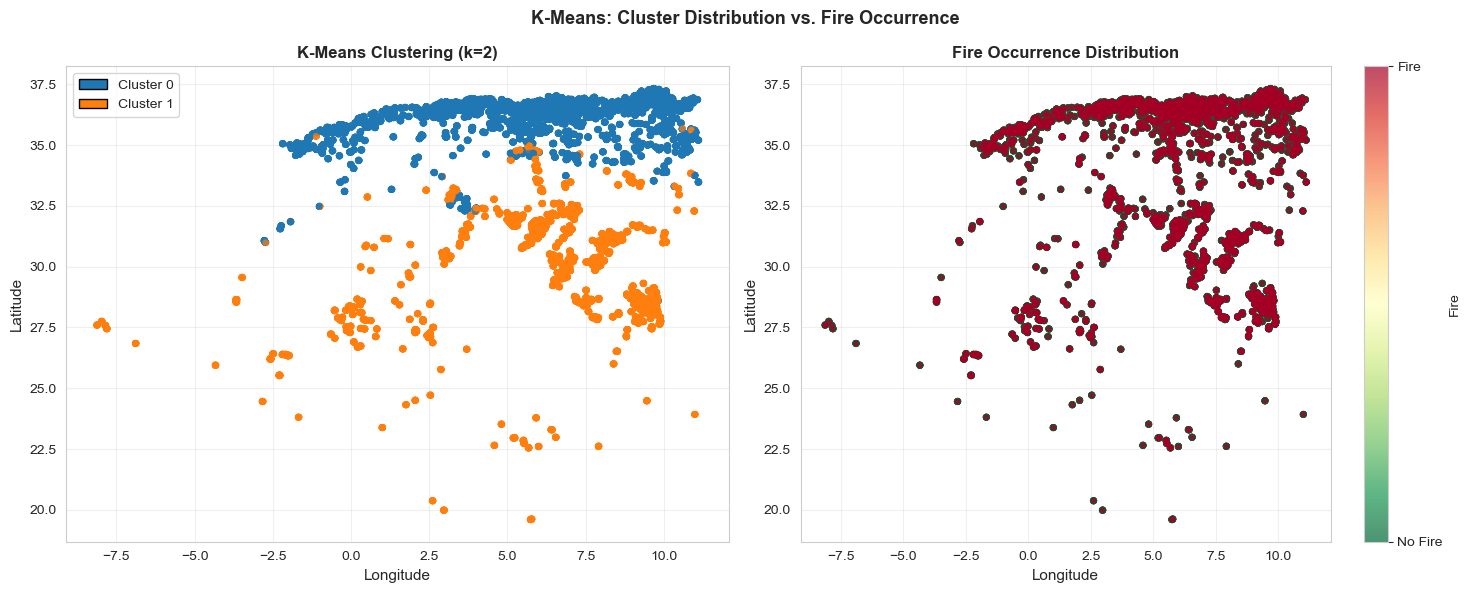


✓ K-Means: Fire Rate by Cluster


,Fire_Count,Total_Samples,Fire_Rate
Cluster,,,
0,3171,33044,9.60
1,11039,28480,38.76


In [ ]:
# K-Means: Clusters vs. Fire Occurrence (Side-by-Side Visualization)
kmeans_labels = loaded_clustering['K-Means']['labels']
if kmeans_labels is not None and fire_col:
    # Get best K-Means configuration (k=2)
    kmeans_clusters = kmeans_labels.iloc[:, 0].values  # First column is best k
    
    # Create spatial plot with proper geographic coordinates
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: K-Means Clusters (Longitude as X, Latitude as Y for correct orientation)
    # Use orange and blue for 2 clusters
    colors_map = {0: '#1f77b4', 1: '#ff7f0e'}  # Blue and Orange
    colors_array = np.array([colors_map.get(int(c), '#cccccc') for c in kmeans_clusters])
    scatter1 = axes[0].scatter(data['longitude'], data['latitude'], 
                               c=colors_array, 
                               alpha=0.7, s=20, edgecolors='none')
    axes[0].set_xlabel('Longitude', fontsize=11)
    axes[0].set_ylabel('Latitude', fontsize=11)
    axes[0].set_title('K-Means Clustering (k=2)', fontweight='bold', fontsize=12)
    
    # Add cluster legend with colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#1f77b4', edgecolor='black', label='Cluster 0'),
                       Patch(facecolor='#ff7f0e', edgecolor='black', label='Cluster 1')]
    axes[0].legend(handles=legend_elements, loc='upper left', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Fire Occurrence
    fire_binary = (data[fire_col] == 1).astype(int)
    scatter2 = axes[1].scatter(data['longitude'], data['latitude'], 
                               c=fire_binary, cmap='RdYlGn_r', 
                               alpha=0.7, s=20, edgecolors='none')
    axes[1].set_xlabel('Longitude', fontsize=11)
    axes[1].set_ylabel('Latitude', fontsize=11)
    axes[1].set_title('Fire Occurrence Distribution', fontweight='bold', fontsize=12)
    cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Fire')
    cbar2.set_ticks([0, 1])
    cbar2.set_ticklabels(['No Fire', 'Fire'])
    axes[1].grid(True, alpha=0.3)
    
    fig.suptitle('K-Means: Cluster Distribution vs. Fire Occurrence', fontsize=13, fontweight='bold')
    fig.tight_layout()
    plt.savefig('f:/DATA/results/final/kmeans_clusters_vs_fire.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Fire rate per cluster
    fire_by_cluster = pd.DataFrame({
        'Cluster': kmeans_clusters,
        'Fire': fire_binary
    }).groupby('Cluster').agg({'Fire': ['sum', 'count', 'mean']})
    fire_by_cluster.columns = ['Fire_Count', 'Total_Samples', 'Fire_Rate']
    fire_by_cluster['Fire_Rate'] = (fire_by_cluster['Fire_Rate'] * 100).round(2)
    
    print("\n✓ K-Means: Fire Rate by Cluster")
    display(fire_by_cluster)
else:
    print("✗ Cannot generate visualization: missing labels or fire column")

In [44]:
# Load original data for fire occurrence visualization
import geopandas as gpd

# Load data
data = pd.read_csv(DATA_PATH)
print(f"✓ Data loaded: {data.shape[0]} samples, {data.shape[1]} features")
print(f"  Columns: {list(data.columns[:10])}...")

# Check if fire column exists
fire_col = None
for col in data.columns:
    if 'fire' in col.lower():
        fire_col = col
        break

if fire_col:
    print(f"✓ Fire column found: '{fire_col}'")
    fire_positive = (data[fire_col] == 1).sum()
    print(f"  Fire occurrences: {fire_positive} / {len(data)} ({100*fire_positive/len(data):.2f}%)")
else:
    print("✗ No fire column found. Checking available columns...")
    print(data.columns.tolist())


✓ Data loaded: 61524 samples, 23 features
  Columns: ['latitude', 'longitude', 'prec_p10', 'tmax_mean', 'tmax_std', 'tmin_mean', 'tmax_max', 't_range', 'gridcode', 'tmax_p10']...
✓ Fire column found: 'fire'
  Fire occurrences: 14210 / 61524 (23.10%)


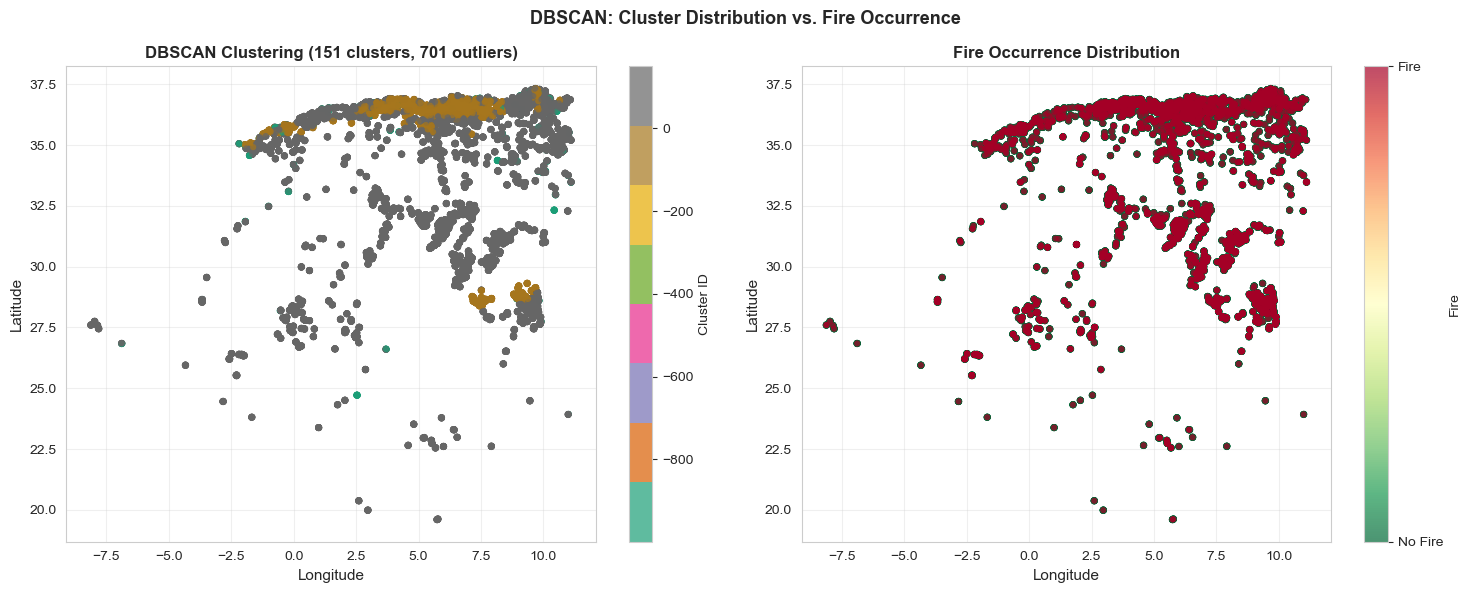


✓ DBSCAN: Fire Rate by Cluster (excluding 701 outliers)


,Fire_Count,Total_Samples,Fire_Rate
Cluster,,,
0,793,7639,10.38
1,31,256,12.11
2,307,2271,13.52
3,71,490,14.49
4,535,1944,27.52
...,...,...,...
146,2,20,10.00
147,3,22,13.64
148,3,33,9.09



  Outliers (Noise) - 23 fires out of 701 samples (3.28%)


In [ ]:
# DBSCAN: Clusters vs. Fire Occurrence (Side-by-Side Visualization)
dbscan_labels = loaded_clustering['DBSCAN']['labels']
if dbscan_labels is not None and fire_col:
    # Get DBSCAN labels (first column)
    dbscan_clusters = dbscan_labels.iloc[:, 0].values
    
    # Identify outliers (-1 label)
    n_clusters_dbscan = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
    n_outliers = (dbscan_clusters == -1).sum()
    
    # Create spatial plot with proper geographic coordinates
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: DBSCAN Clusters (Longitude as X, Latitude as Y for correct orientation)
    colors = dbscan_clusters.copy().astype(float)
    colors[colors == -1] = -999  # Distinct value for outliers
    scatter1 = axes[0].scatter(data['longitude'], data['latitude'], 
                               c=colors, cmap='Dark2', 
                               alpha=0.7, s=20, edgecolors='none')
    axes[0].set_xlabel('Longitude', fontsize=11)
    axes[0].set_ylabel('Latitude', fontsize=11)
    axes[0].set_title(f'DBSCAN Clustering ({n_clusters_dbscan} clusters, {n_outliers} outliers)', 
                      fontweight='bold', fontsize=12)
    plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Fire Occurrence
    fire_binary = (data[fire_col] == 1).astype(int)
    scatter2 = axes[1].scatter(data['longitude'], data['latitude'], 
                               c=fire_binary, cmap='RdYlGn_r', 
                               alpha=0.7, s=20, edgecolors='none')
    axes[1].set_xlabel('Longitude', fontsize=11)
    axes[1].set_ylabel('Latitude', fontsize=11)
    axes[1].set_title('Fire Occurrence Distribution', fontweight='bold', fontsize=12)
    cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Fire')
    cbar2.set_ticks([0, 1])
    cbar2.set_ticklabels(['No Fire', 'Fire'])
    axes[1].grid(True, alpha=0.3)
    
    fig.suptitle('DBSCAN: Cluster Distribution vs. Fire Occurrence', fontsize=13, fontweight='bold')
    fig.tight_layout()
    plt.savefig('f:/DATA/results/final/dbscan_clusters_vs_fire.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Fire rate per cluster (exclude outliers for clarity)
    dbscan_with_fire = pd.DataFrame({
        'Cluster': dbscan_clusters,
        'Fire': fire_binary
    })
    fire_by_cluster = dbscan_with_fire[dbscan_with_fire['Cluster'] != -1].groupby('Cluster').agg({'Fire': ['sum', 'count', 'mean']})
    fire_by_cluster.columns = ['Fire_Count', 'Total_Samples', 'Fire_Rate']
    fire_by_cluster['Fire_Rate'] = (fire_by_cluster['Fire_Rate'] * 100).round(2)
    
    # Outlier fire rate
    outlier_fire_rate = round(dbscan_with_fire[dbscan_with_fire['Cluster'] == -1]['Fire'].mean() * 100, 2)
    outlier_count = int(dbscan_with_fire[dbscan_with_fire['Cluster'] == -1]['Fire'].sum())
    
    print(f"\n✓ DBSCAN: Fire Rate by Cluster (excluding {n_outliers} outliers)")
    display(fire_by_cluster)
    print(f"\n  Outliers (Noise) - {outlier_count} fires out of {n_outliers} samples ({outlier_fire_rate}%)")
else:
    print("✗ Cannot generate visualization: missing labels or fire column")


C:\Users\HP\AppData\Local\Temp\ipykernel_14704\2079355669.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  dark2_cmap = get_cmap('Dark2')


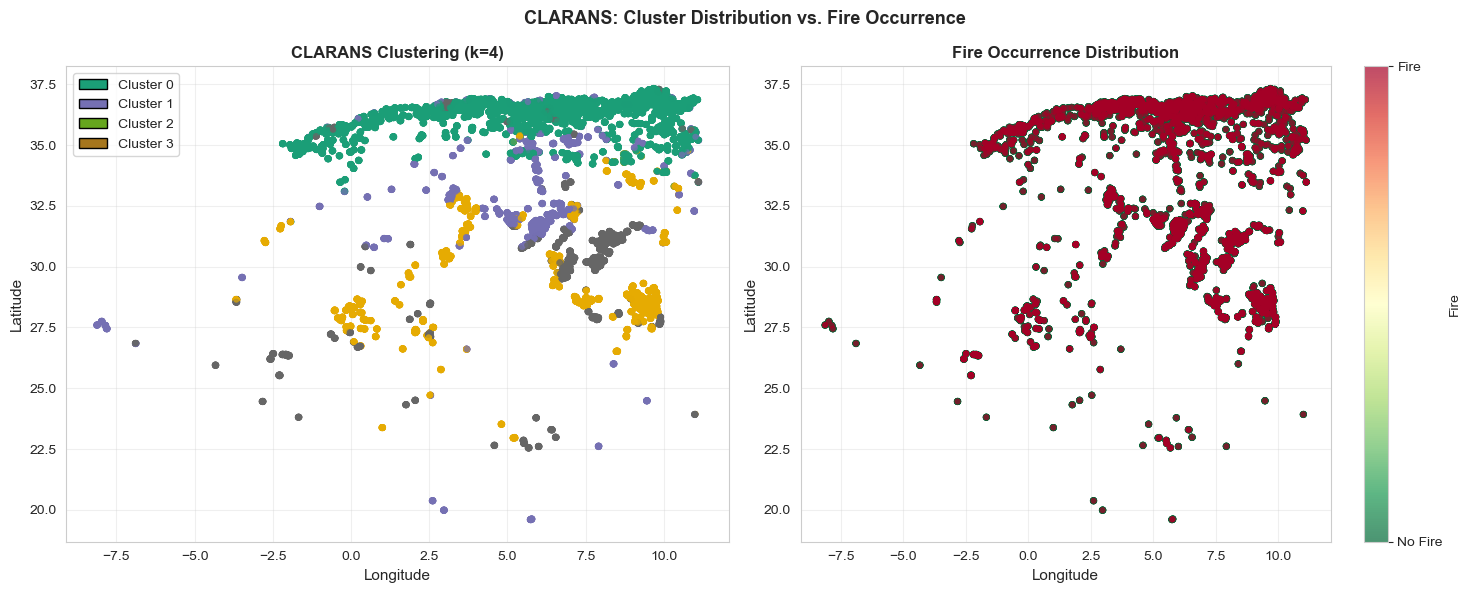


✓ CLARANS: Fire Rate by Cluster


,Fire_Count,Total_Samples,Fire_Rate
Cluster,,,
0,2793,29662,9.42
1,4625,11191,41.33
2,2645,10260,25.78
3,4147,10411,39.83


In [ ]:
# CLARANS: Clusters vs. Fire Occurrence (Side-by-Side Visualization)
clarans_labels = loaded_clustering['CLARANS']['labels']
if clarans_labels is not None and fire_col:
    # Get CLARANS labels (first column)
    clarans_clusters = clarans_labels.iloc[:, 0].values
    
    # Create spatial plot with proper geographic coordinates
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: CLARANS Clusters (Longitude as X, Latitude as Y for correct orientation)
    scatter1 = axes[0].scatter(data['longitude'], data['latitude'], 
                               c=clarans_clusters, cmap='Dark2', 
                               alpha=0.7, s=20, edgecolors='none')
    axes[0].set_xlabel('Longitude', fontsize=11)
    axes[0].set_ylabel('Latitude', fontsize=11)
    axes[0].set_title(f'CLARANS Clustering (k={len(set(clarans_clusters))})', 
                      fontweight='bold', fontsize=12)
    
    # Add cluster legend with Dark2 colors
    from matplotlib.patches import Patch
    from matplotlib.cm import get_cmap
    dark2_cmap = get_cmap('Dark2')
    unique_clusters = sorted(set(clarans_clusters))
    legend_elements = [Patch(facecolor=dark2_cmap(i/len(unique_clusters)), edgecolor='black', label=f'Cluster {int(c)}')
                       for i, c in enumerate(unique_clusters)]
    axes[0].legend(handles=legend_elements, loc='upper left', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Fire Occurrence
    fire_binary = (data[fire_col] == 1).astype(int)
    scatter2 = axes[1].scatter(data['longitude'], data['latitude'], 
                               c=fire_binary, cmap='RdYlGn_r', 
                               alpha=0.7, s=20, edgecolors='none')
    axes[1].set_xlabel('Longitude', fontsize=11)
    axes[1].set_ylabel('Latitude', fontsize=11)
    axes[1].set_title('Fire Occurrence Distribution', fontweight='bold', fontsize=12)
    cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Fire')
    cbar2.set_ticks([0, 1])
    cbar2.set_ticklabels(['No Fire', 'Fire'])
    axes[1].grid(True, alpha=0.3)
    
    fig.suptitle('CLARANS: Cluster Distribution vs. Fire Occurrence', fontsize=13, fontweight='bold')
    fig.tight_layout()
    plt.savefig('f:/DATA/results/final/clarans_clusters_vs_fire.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Fire rate per cluster
    fire_by_cluster = pd.DataFrame({
        'Cluster': clarans_clusters,
        'Fire': fire_binary
    }).groupby('Cluster').agg({'Fire': ['sum', 'count', 'mean']})
    fire_by_cluster.columns = ['Fire_Count', 'Total_Samples', 'Fire_Rate']
    fire_by_cluster['Fire_Rate'] = (fire_by_cluster['Fire_Rate'] * 100).round(2)
    
    print("\n✓ CLARANS: Fire Rate by Cluster")
    display(fire_by_cluster)
else:
    print("✗ Cannot generate visualization: missing labels or fire column")

## Standalone Visualizations for Report

C:\Users\HP\AppData\Local\Temp\ipykernel_14704\3096474721.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  dark2_cmap_grid = get_cmap('Dark2')



✓ Fire Occurrence + Clustering Models (2x2 grid) saved to: f:/DATA/results/plots_notebook/fire_occurrence_map.png


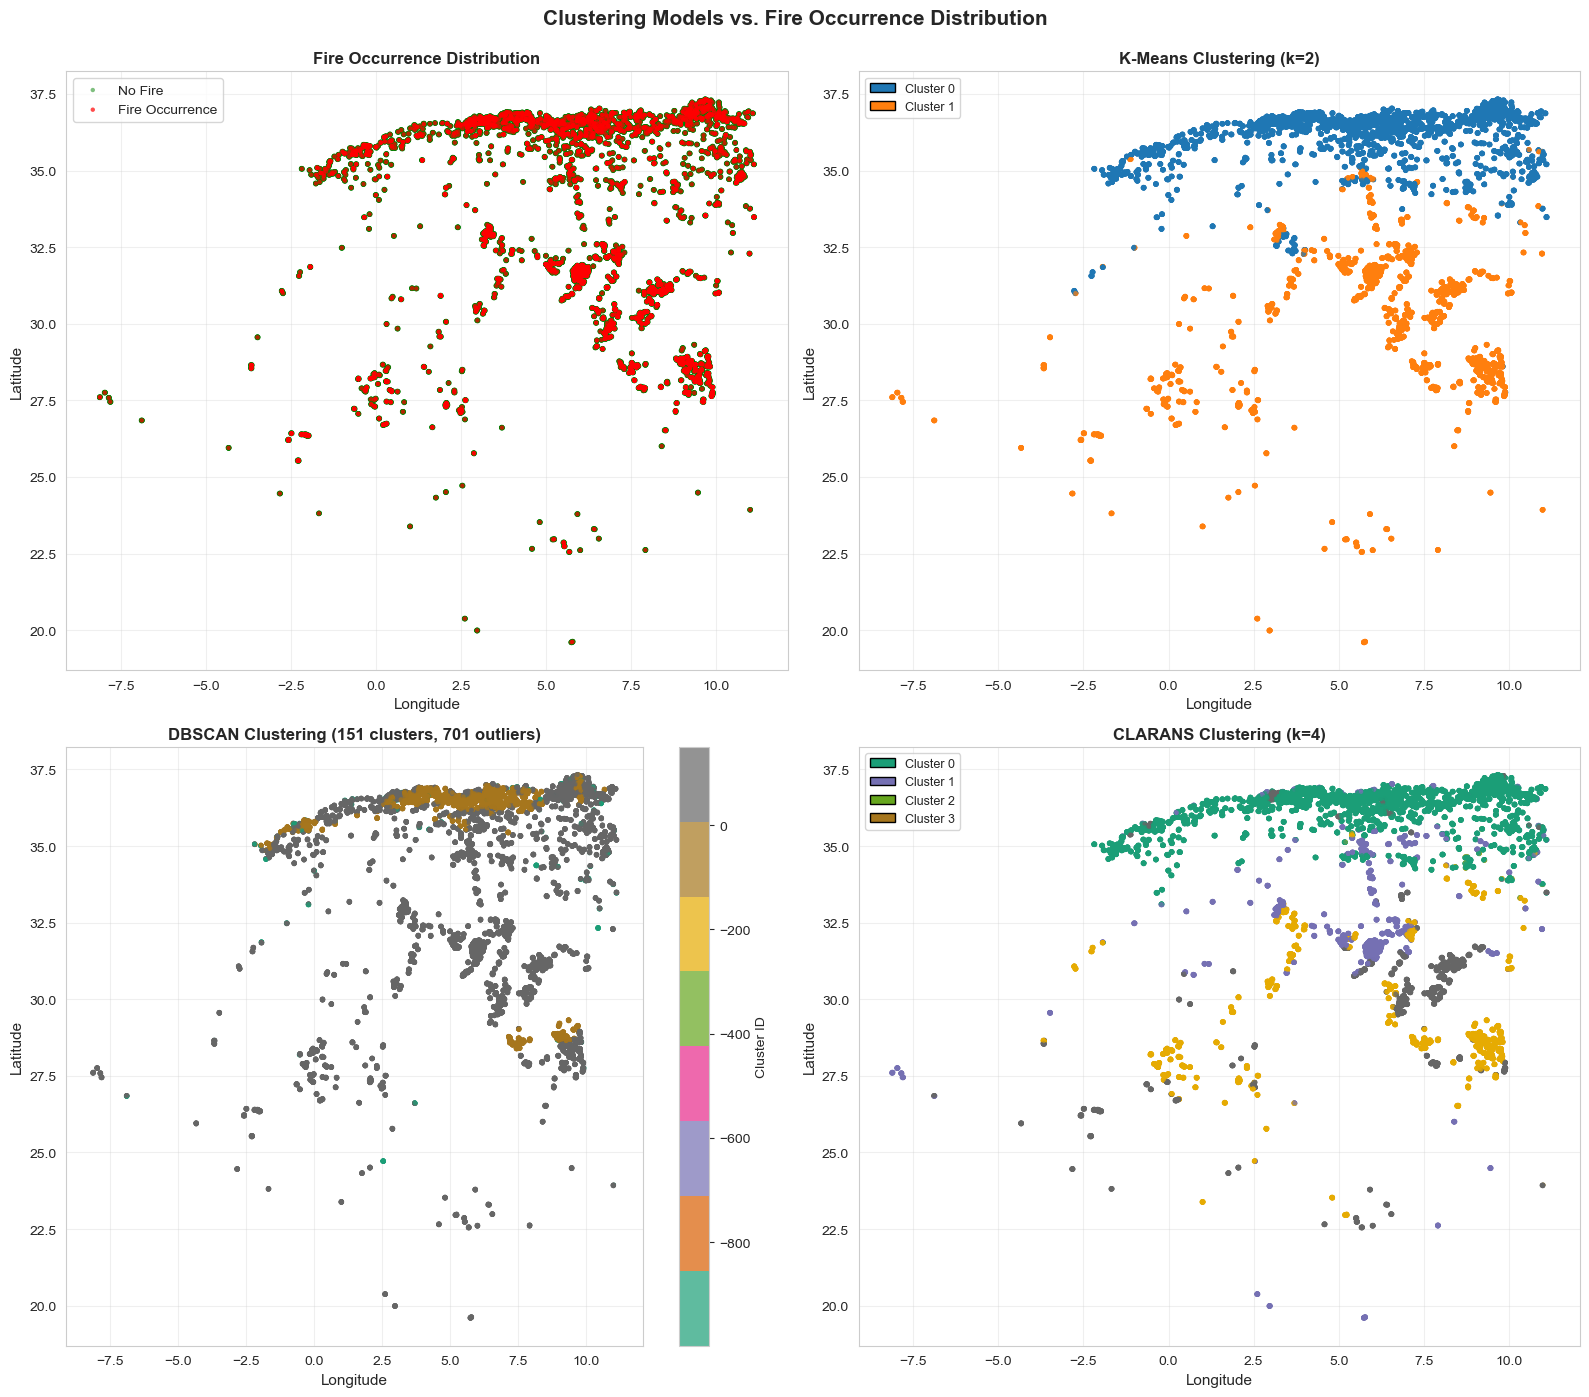


Fire Statistics:
  Total fire events: 14210
  Total samples: 61524
  Overall fire rate: 23.10%


In [ ]:
# STANDALONE: 2x2 Grid - Fire Occurrence + All Clustering Models
if 'data' in locals() and 'fire_col' in locals() and fire_col is not None:
    if 'kmeans_clusters' in locals() and 'dbscan_clusters' in locals() and 'clarans_clusters' in locals():
        fig, axes = plt.subplots(2, 2, figsize=(16, 14))
        
        # Extract fire data
        fire_binary = (data[fire_col] == 1).astype(int)
        
        # Plot 1 (top-left): Fire Occurrence Map
        no_fire_mask = fire_binary == 0
        fire_mask = fire_binary == 1
        
        axes[0, 0].scatter(data[no_fire_mask]['longitude'], data[no_fire_mask]['latitude'], 
                           c='green', alpha=0.5, s=10, label='No Fire', edgecolors='none')
        axes[0, 0].scatter(data[fire_mask]['longitude'], data[fire_mask]['latitude'], 
                           c='red', alpha=0.7, s=10, label='Fire Occurrence', edgecolors='none')
        axes[0, 0].set_xlabel('Longitude', fontsize=11)
        axes[0, 0].set_ylabel('Latitude', fontsize=11)
        axes[0, 0].set_title('Fire Occurrence Distribution', fontweight='bold', fontsize=12)
        axes[0, 0].legend(loc='upper left', fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2 (top-right): K-Means Clusters
        from matplotlib.patches import Patch
        colors_map_km = {0: '#1f77b4', 1: '#ff7f0e'}  # Blue and Orange
        colors_array_km = np.array([colors_map_km.get(int(c), '#cccccc') for c in kmeans_clusters])
        scatter2 = axes[0, 1].scatter(data['longitude'], data['latitude'], 
                                      c=colors_array_km, 
                                      alpha=0.7, s=10, edgecolors='none')
        axes[0, 1].set_xlabel('Longitude', fontsize=11)
        axes[0, 1].set_ylabel('Latitude', fontsize=11)
        axes[0, 1].set_title('K-Means Clustering (k=2)', fontweight='bold', fontsize=12)
        legend_elements_km = [Patch(facecolor='#1f77b4', edgecolor='black', label='Cluster 0'),
                              Patch(facecolor='#ff7f0e', edgecolor='black', label='Cluster 1')]
        axes[0, 1].legend(handles=legend_elements_km, loc='upper left', fontsize=9)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3 (bottom-left): DBSCAN Clusters
        colors_dbscan = dbscan_clusters.copy().astype(float)
        colors_dbscan[colors_dbscan == -1] = -999  # Distinct value for outliers
        scatter3 = axes[1, 0].scatter(data['longitude'], data['latitude'], 
                                      c=colors_dbscan, cmap='Dark2', 
                                      alpha=0.7, s=10, edgecolors='none')
        n_clusters_dbscan = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
        n_outliers = (dbscan_clusters == -1).sum()
        axes[1, 0].set_xlabel('Longitude', fontsize=11)
        axes[1, 0].set_ylabel('Latitude', fontsize=11)
        axes[1, 0].set_title(f'DBSCAN Clustering ({n_clusters_dbscan} clusters, {n_outliers} outliers)', 
                             fontweight='bold', fontsize=12)
        plt.colorbar(scatter3, ax=axes[1, 0], label='Cluster ID')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4 (bottom-right): CLARANS Clusters
        from matplotlib.cm import get_cmap
        scatter4 = axes[1, 1].scatter(data['longitude'], data['latitude'], 
                                      c=clarans_clusters, cmap='Dark2', 
                                      alpha=0.7, s=10, edgecolors='none')
        axes[1, 1].set_xlabel('Longitude', fontsize=11)
        axes[1, 1].set_ylabel('Latitude', fontsize=11)
        axes[1, 1].set_title(f'CLARANS Clustering (k={len(set(clarans_clusters))})', 
                             fontweight='bold', fontsize=12)
        dark2_cmap_grid = get_cmap('Dark2')
        unique_clusters_grid = sorted(set(clarans_clusters))
        legend_elements_clarans = [Patch(facecolor=dark2_cmap_grid(i/len(unique_clusters_grid)), edgecolor='black', label=f'Cluster {int(c)}')
                                  for i, c in enumerate(unique_clusters_grid)]
        axes[1, 1].legend(handles=legend_elements_clarans, loc='upper left', fontsize=9)
        axes[1, 1].grid(True, alpha=0.3)
        
        fig.suptitle('Clustering Models vs. Fire Occurrence Distribution', fontsize=15, fontweight='bold', y=0.995)
        fig.tight_layout()
        
        # Save figure
        output_path = 'f:/DATA/results/final/fire_occurrence_map.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Fire Occurrence + Clustering Models (2x2 grid) saved to: {output_path}")
        plt.show()
        
        # Print statistics
        fire_count = fire_binary.sum()
        total_count = len(fire_binary)
        fire_rate = (fire_count / total_count * 100)
        print(f"\nFire Statistics:")
        print(f"  Total fire events: {int(fire_count)}")
        print(f"  Total samples: {total_count}")
        print(f"  Overall fire rate: {fire_rate:.2f}%")
    else:
        print("✗ Clustering models not loaded")
else:
    print("✗ Data or fire column not available")

In [ ]:
# STANDALONE: K-Means Fire Rate Table (CSV Export)
if 'kmeans_clusters' in locals() and 'fire_col' in locals() and fire_col is not None:
    fire_binary = (data[fire_col] == 1).astype(int)
    
    kmeans_fire = pd.DataFrame({
        'Cluster': kmeans_clusters,
        'Fire': fire_binary
    })
    
    fire_by_cluster = kmeans_fire.groupby('Cluster').agg({'Fire': ['sum', 'count', 'mean']})
    fire_by_cluster.columns = ['Fire_Count', 'Total_Samples', 'Fire_Rate']
    fire_by_cluster['Fire_Rate'] = (fire_by_cluster['Fire_Rate'] * 100).round(2)
    fire_by_cluster = fire_by_cluster.reset_index()
    
    # Save as CSV
    output_path = 'f:/DATA/results/final/kmeans_fire_rate_table.csv'
    fire_by_cluster.to_csv(output_path, index=False)
    print(f"\n✓ K-Means Fire Rate Table saved to: {output_path}")
    display(fire_by_cluster)
else:
    print("✗ K-Means clusters not available")


✓ K-Means Fire Rate Table saved to: f:/DATA/results/plots_notebook/kmeans_fire_rate_table.csv


,Cluster,Fire_Count,Total_Samples,Fire_Rate
0,0,3171,33044,9.60
1,1,11039,28480,38.76


In [ ]:
# STANDALONE: DBSCAN Fire Rate Table (CSV Export)
if 'dbscan_clusters' in locals() and 'fire_col' in locals() and fire_col is not None:
    fire_binary = (data[fire_col] == 1).astype(int)
    
    dbscan_fire = pd.DataFrame({
        'Cluster': dbscan_clusters,
        'Fire': fire_binary
    })
    
    fire_by_cluster = dbscan_fire.groupby('Cluster').agg({'Fire': ['sum', 'count', 'mean']})
    fire_by_cluster.columns = ['Fire_Count', 'Total_Samples', 'Fire_Rate']
    fire_by_cluster['Fire_Rate'] = (fire_by_cluster['Fire_Rate'] * 100).round(2)
    fire_by_cluster = fire_by_cluster.reset_index()
    fire_by_cluster = fire_by_cluster.sort_values('Fire_Rate', ascending=False).reset_index(drop=True)
    
    # Save as CSV
    output_path = 'f:/DATA/results/final/dbscan_fire_rate_table.csv'
    fire_by_cluster.to_csv(output_path, index=False)
    print(f"\n✓ DBSCAN Fire Rate Table saved to: {output_path}")
    
    print(f"\nDBSCAN Summary: {len(fire_by_cluster)} total clusters + outliers")
    print(f"Fire rate range: {fire_by_cluster['Fire_Rate'].min():.2f}% - {fire_by_cluster['Fire_Rate'].max():.2f}%")
    display(fire_by_cluster.head(20))
else:
    print("✗ DBSCAN clusters not available")


✓ DBSCAN Fire Rate Table saved to: f:/DATA/results/plots_notebook/dbscan_fire_rate_table.csv

DBSCAN Summary: 152 total clusters + outliers
Fire rate range: 2.70% - 80.26%


,Cluster,Fire_Count,Total_Samples,Fire_Rate
0,89,183,228,80.26
1,26,3255,5738,56.73
2,118,34,66,51.52
3,86,52,102,50.98
4,11,3684,7661,48.09
5,142,23,48,47.92
6,67,84,180,46.67
7,10,1126,3008,37.43
8,39,25,71,35.21
9,12,547,1613,33.91


In [ ]:
# STANDALONE: CLARANS Fire Rate Table (CSV Export)
if 'clarans_clusters' in locals() and 'fire_col' in locals() and fire_col is not None:
    fire_binary = (data[fire_col] == 1).astype(int)
    
    clarans_fire = pd.DataFrame({
        'Cluster': clarans_clusters,
        'Fire': fire_binary
    })
    
    fire_by_cluster = clarans_fire.groupby('Cluster').agg({'Fire': ['sum', 'count', 'mean']})
    fire_by_cluster.columns = ['Fire_Count', 'Total_Samples', 'Fire_Rate']
    fire_by_cluster['Fire_Rate'] = (fire_by_cluster['Fire_Rate'] * 100).round(2)
    fire_by_cluster = fire_by_cluster.reset_index()
    fire_by_cluster = fire_by_cluster.sort_values('Fire_Rate', ascending=False).reset_index(drop=True)
    
    # Save as CSV
    output_path = 'f:/DATA/results/final/clarans_fire_rate_table.csv'
    fire_by_cluster.to_csv(output_path, index=False)
    print(f"\n✓ CLARANS Fire Rate Table saved to: {output_path}")
    display(fire_by_cluster)
else:
    print("✗ CLARANS clusters not available")


✓ CLARANS Fire Rate Table saved to: f:/DATA/results/plots_notebook/clarans_fire_rate_table.csv


,Cluster,Fire_Count,Total_Samples,Fire_Rate
0,1,4625,11191,41.33
1,3,4147,10411,39.83
2,2,2645,10260,25.78
3,0,2793,29662,9.42
